# Кроссвалидация для временных рядов

В этом воркшопе мы разберём способ кроссвалидации для временных рядов, сравним несколько моделей и подберём их параметры посредством кроссвалидации.

Работать будем с данными о продажах товара за месяц.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [25]:
df = pd.read_csv('data/hw_daily-temperatures.csv', index_col=['date'], parse_dates=True)
df.head()

,temp
date,
1987-10-18,10.1
1987-10-19,11.3
1987-10-20,10.4
1987-10-21,10.9
1987-10-22,9.2


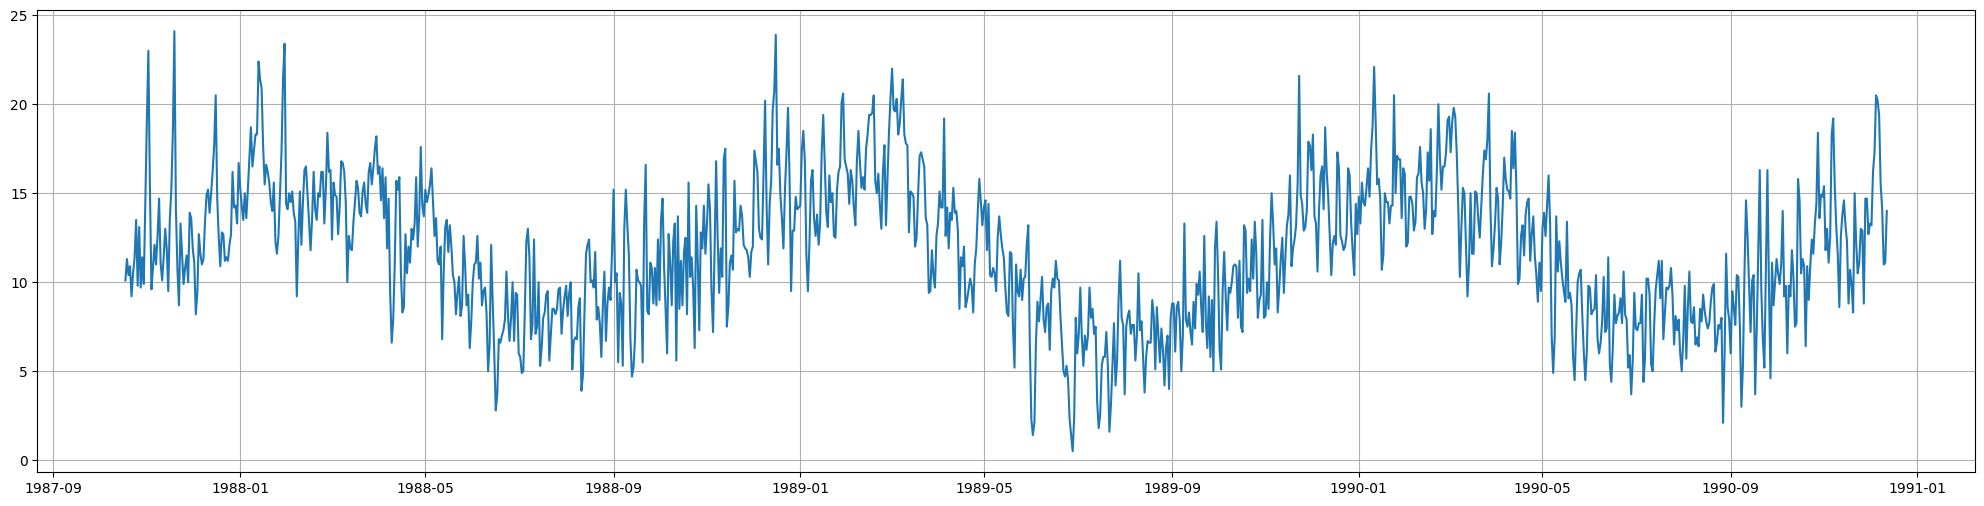

In [26]:
plt.figure(figsize=(25, 6))
plt.plot(df['temp'])
plt.grid(True)
plt.show()

Попробуем построить временной ряд методом тройного экспоненциального сглаживания.

(код функции взят из первого воркшопа по временным рядам)

In [27]:
def trippleExpSmoothing(df, n_seasonal_components, alpha, beta, gamma, n_predictions):
    smoothed = [df['temp'].iloc[0]]
    
    for i in range(len(df) + n_predictions):
        if i == 0:
            # инициализируем начальные компоненты, включая все сезонные
            # уровень - просто первая компонента
            smooth = df['temp'].iloc[0]

            # инициализируем тренд средним по всем сезонным компонентам
            total_sum = 0.0
            for k in range(n_seasonal_components):
                total_sum += float(df['temp'].iloc[k + n_seasonal_components] - df['temp'].iloc[k]) / n_seasonal_components
            trend = total_sum / n_seasonal_components

            # инициализируем сезонные компоненты
            seasonals = dict()  # словарь {номер сезона: значение}
            n_seasons = int(len(df) / n_seasonal_components)
            season_averages = []
            # для начала считаем среднее (уровень) по сезонам
            for j in range(n_seasons):
                season_averages.append(
                    sum(df['temp'].iloc[n_seasonal_components * j : n_seasonal_components * (j + 1)])
                    / float(n_seasonal_components)
                )
            # после чего вычитаем среднее из значений ряда
            for k in range(n_seasonal_components):
                sum_of_vals_over_avg = 0.0
                for j in range(n_seasons):
                    sum_of_vals_over_avg += df['temp'].iloc[n_seasonal_components * j + k] - season_averages[j]
                seasonals[k] = sum_of_vals_over_avg / n_seasons

        
        if i >= len(df):  # предсказание
            m = i - len(df) + 1
            smoothed.append((smooth + m * trend) + seasonals[i % n_seasonal_components])

        
        else:
            val = df['temp'].iloc[i]
            
            last_smooth = smooth 
            smooth = alpha * (val - seasonals[i % n_seasonal_components]) + (1 - alpha) * (smooth + trend)
            
            trend = beta * (smooth - last_smooth) + (1 - beta) * trend
            
            seasonals[i % n_seasonal_components] = gamma * (val - smooth) + (1 - gamma) * seasonals[i % n_seasonal_components]
            
            smoothed.append(smooth + trend + seasonals[i % n_seasonal_components])
            
    # продлеваем индекс под прогнозные данные
    tmp_index = df.index.tolist()
    n_additional_periods = len(smoothed) - len(tmp_index)
    for i in range(n_additional_periods):
        tmp_index.append(tmp_index[-1] + pd.DateOffset(months=1))
    
    tmp_df = pd.DataFrame({'temp': df['temp'].tolist() + [np.nan] * n_additional_periods,
                           'yhat': smoothed}, index=tmp_index)

    # сдвигаем результаты на 1 влево
    tmp_df['yhat'] = tmp_df['yhat'].shift(-1)
    tmp_df = tmp_df[:-1]

    return tmp_df

In [28]:
res = trippleExpSmoothing(df, 12, 0.5, 0.5, 0.5, 12)

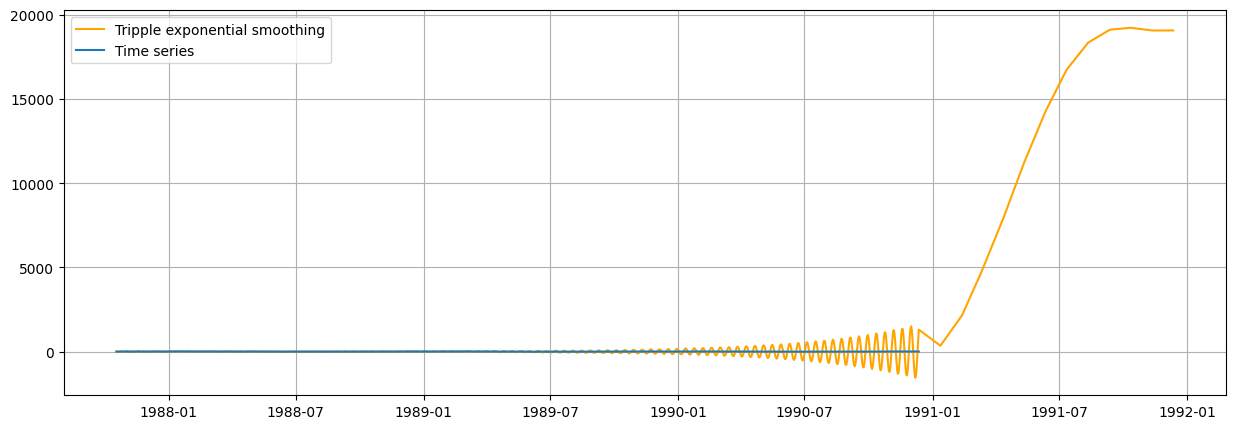

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(res['yhat'], "orange", label="Tripple exponential smoothing")
plt.plot(res['temp'], label="Time series")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

Попадание в график почти полное, но прогнозные результаты неадекватные. Очень похоже на оверфиттинг. 

Подготовим сплиты для кроссвалидации.

In [30]:
def make_time_series_splits(df, n_splits=5, val_ratio=0.2):
    X = np.array(df.index.tolist())
    Y = np.array(df['temp'].tolist())

    split_indices = list(range(len(df), 0, -len(df) // n_splits))[::-1]

    splits = []  # список сплитов вида [x_train, y_train, x_val, y_val]
    
    for end in split_indices:
        x_train = X[:round(end * (1 - val_ratio))]
        x_val = X[round(end * (1 - val_ratio)):end]

        y_train = Y[:round(end * (1 - val_ratio))]
        y_val = Y[round(end * (1 - val_ratio)):end]

        splits.append([x_train, y_train, x_val, y_val])

    return splits

In [31]:
splits = make_time_series_splits(df)

Проверим различные комбинации параметров на всех сплитах и посчитаем средний MAPE по сплитам. 

Вариант с наилучшим MAPE обучим на всём датасете.

In [21]:
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm
from itertools import product

# варианты параметров
alphas = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 0.95]
betas = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 0.95]
gammas = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 0.95]

params_list = list(product(alphas, betas, gammas))

# в этом датафрейме будем хранить результаты прогонов с разными параметрами
df_res = pd.DataFrame(columns=['alpha', 'beta', 'gamma', 'mape'])

for params in tqdm(params_list):
    sum_mape = 0
    for split in splits:
        # делаем временный датафрейм из сплита
        tmp_df = pd.DataFrame({'temp': split[1]}, index=split[0])
        prediction_length = len(split[3])

        # строим модель с текущей комбинацией параметров и сразу с прогнозом на валидацию
        res = trippleExpSmoothing(tmp_df, 12, params[0], params[1], params[2], prediction_length)

        # считаем MAPE между валидацией из данного сплита и прогнозным "кончиком" датафрейма
        mape = mean_absolute_percentage_error(split[3], res['yhat'].to_numpy()[-prediction_length:])
        sum_mape += mape
        
    mean_mape = sum_mape / len(splits)

    append_df = pd.DataFrame({'alpha': [params[0]],
                             'beta': [params[1]],
                             'gamma': [params[2]],
                             'mape': [mean_mape]})

    df_res = pd.concat([df_res, append_df])


100%|██████████| 3375/3375 [04:58<00:00, 11.32it/s]


In [32]:
df_res.sort_values(by='mape')

,alpha,beta,gamma,mape
0,0.05,0.05,0.60,3.723762e-01
0,0.05,0.05,0.50,3.725718e-01
0,0.05,0.05,0.65,3.729106e-01
0,0.05,0.05,0.45,3.735172e-01
0,0.05,0.05,0.70,3.738885e-01
...,...,...,...,...
0,0.25,0.90,0.95,5.715667e+14
0,0.25,0.95,0.95,8.264441e+14
0,0.20,0.95,0.90,1.480452e+15
0,0.20,0.90,0.95,4.979166e+15


Теперь можем построить модель с параметрами с лучшим MAPE

In [33]:
res = trippleExpSmoothing(df, 12, 0.05, 0.05, 0.5, 12)

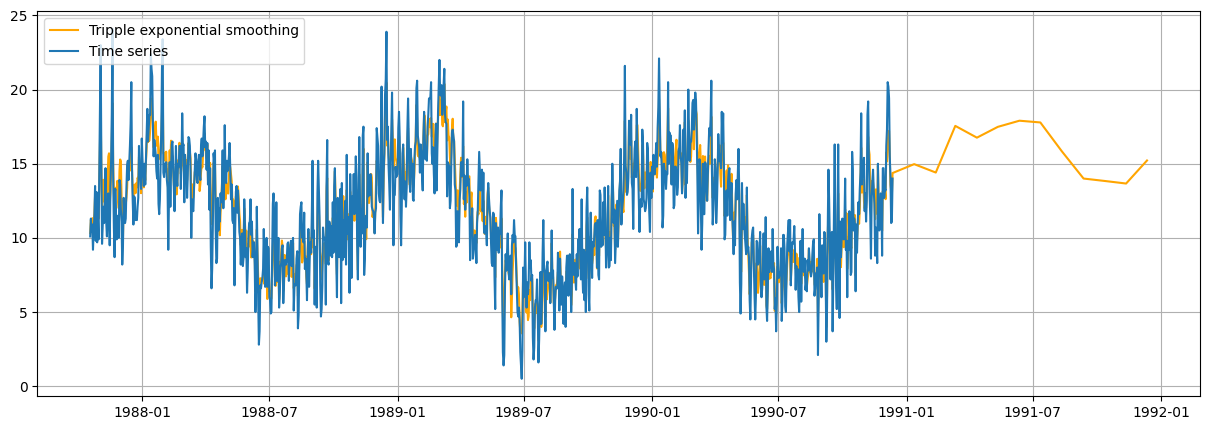

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(res['yhat'], "orange", label="Tripple exponential smoothing")
plt.plot(res['temp'], label="Time series")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

Вот такие получилось подобрать параметры!